In [8]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu,sentence_bleu



In [9]:

text_pairs = pd.read_csv('../File/df_corpus_linguistico_preprocesado.csv',
                 sep='\t', encoding='utf-8', index_col=0)


In [10]:

# Divide en conjuntos de entrenamiento, validación y prueba

train_pairs, test_val_pairs = train_test_split(text_pairs, test_size=0.3)  # 70% para entrenamiento, 30% para prueba + validación

val_pairs, test_pairs = train_test_split(test_val_pairs, test_size=0.5)  # Dividir la mitad del 30% para validación y la otra mitad para prueba



## Tokenización de frases

In [8]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64

# Vectorización de texto en inglés y español (tokenización y codificación) con TextVectorization de Keras 
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)


In [9]:
def format_dataset(eng, spa):
    eng = eng_vectorization(eng)                    # Vectorización de texto en inglés
    spa = spa_vectorization(spa)                    # Vectorización de texto en español
    return ({"encoder_inputs": eng, "decoder_inputs": spa[:, :-1], }, spa[:, 1:])


def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)


In [10]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

2023-05-15 18:41:42.735124: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype int64
	 [[{{node Placeholder/_7}}]]
2023-05-15 18:41:42.735638: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype int64
	 [[{{node Placeholder/_7}}]]


inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


2023-05-15 18:41:43.136048: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# Definir modelo

In [11]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


In [12]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [13]:
epochs = 30 

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# save best Model
checkpoint_filepath = 'model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


transformer.fit(train_ds, epochs=epochs, validation_data=val_ds,
                callbacks=[model_checkpoint_callback])


Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 positional_embedding (Posi  (None, None, 256)            3845120   ['encoder_inputs[0][0]']      
 tionalEmbedding)                                                                                 
                                                                                                  
 decoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                      

2023-05-15 18:43:00.475572: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype int64
	 [[{{node Placeholder/_7}}]]
2023-05-15 18:43:00.475854: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype resource
	 [[{{node Placeholder/_6}}]]


1302/1302 [==============================] - ETA: 0s - loss: 4.0963 - accuracy: 0.4280

2023-05-15 18:53:07.359651: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int64
	 [[{{node Placeholder/_13}}]]
2023-05-15 18:53:07.360066: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17844]
	 [[{{node Placeholder/_0}}]]


1302/1302 [==============================] - 661s 506ms/step - loss: 4.0963 - accuracy: 0.4280 - val_loss: 3.2140 - val_accuracy: 0.5208
Epoch 2/30
1302/1302 [==============================] - 700s 538ms/step - loss: 3.2542 - accuracy: 0.5420 - val_loss: 2.8518 - val_accuracy: 0.5752
Epoch 3/30
1302/1302 [==============================] - 713s 548ms/step - loss: 2.8895 - accuracy: 0.5886 - val_loss: 2.6712 - val_accuracy: 0.6044
Epoch 4/30
1302/1302 [==============================] - 754s 579ms/step - loss: 2.6805 - accuracy: 0.6191 - val_loss: 2.5365 - val_accuracy: 0.6272
Epoch 5/30
1302/1302 [==============================] - 811s 623ms/step - loss: 2.5697 - accuracy: 0.6401 - val_loss: 2.4946 - val_accuracy: 0.6355
Epoch 6/30
1302/1302 [==============================] - 834s 641ms/step - loss: 2.4996 - accuracy: 0.6546 - val_loss: 2.4924 - val_accuracy: 0.6430
Epoch 7/30
1302/1302 [==============================] - 795s 610ms/step - loss: 2.4514 - accuracy: 0.6664 - val_loss: 2.453

### Gráfica sobre los valores de pérdida y presición del historial del modelo

Como no se guardó el history, se crearon variables con el valor de el error y presición en cada época.

In [13]:

loss = [4.0963, 3.2542, 2.8895, 2.6805, 2.5697, 2.4996, 2.4514, 2.4131, 2.3781, 2.3463, 2.3186, 2.2911, 2.2640, 1.9437, 1.9291]
accuracy = [0.4280, 0.5420, 0.5886, 0.6191, 0.6401, 0.6546, 0.6664, 0.6764, 0.6846, 0.6921, 0.6989, 0.7044, 0.7101, 0.7621, 0.7648]
val_loss = [3.2140, 2.8518, 2.6712, 2.5365, 2.4946, 2.4924, 2.4530, 2.4403, 2.4501, 2.4487, 2.4561, 2.4548, 2.4547, 2.6241, 2.6306]
val_accuracy = [0.5208, 0.5752, 0.6044, 0.6272, 0.6355, 0.6430, 0.6499, 0.6557, 0.6556, 0.6565, 0.6585, 0.6619, 0.6640, 0.6620, 0.6643]

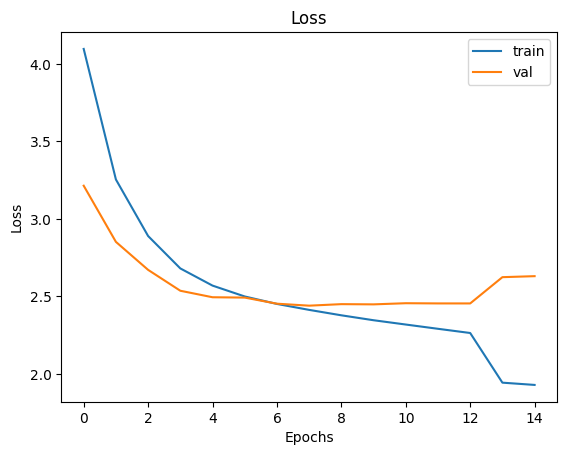

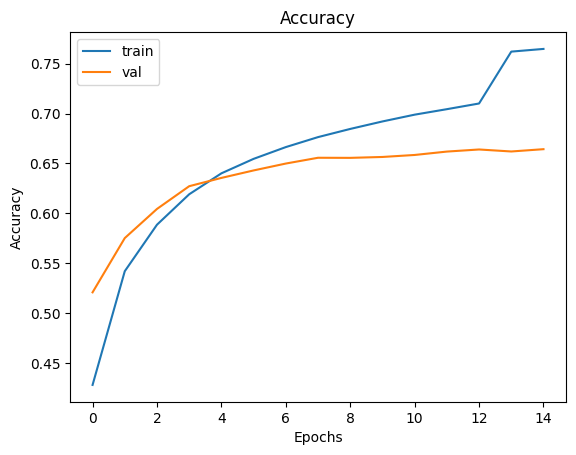

In [14]:
# Gráfica de la pérdida
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['train', 'val'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Gráfica de la precisión
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.legend(['train', 'val'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Luego de graficar se puede observar que el modelo comienza a sobreajustar a partir de la época 5.

In [15]:
# load best Model
model = transformer.load_weights(checkpoint_filepath)


# Evaluación del modelo

In [17]:
# Evalua el modelo

score_train = transformer.evaluate(train_ds)
score_val = transformer.evaluate(val_ds)

print('Train loss:', score_train[0])
print('Train accuracy:', score_train[1])
print('Val loss:', score_val[0])
print('Val accuracy:', score_val[1])



279/279 [==============================] - 56s 199ms/step - loss: 2.4403 - accuracy: 0.6557
Train loss: 2.2172207832336426
Train accuracy: 0.7013234496116638
Val loss: 2.440272808074951
Val accuracy: 0.6557062864303589


## Traducción de frases

In [37]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[
            :, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

dict=[]

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)
    dict.append([input_sentence, translated[:-5]])
    print(f"Input: {input_sentence}")
    print(f"Translated: {translated[:-5]}")


Input: Whatever happens, you must keep calm.
Translated: [start] todo lo que tienes que hacer la [UNK] 
Input: You'll find nothing here.
Translated: [start] no [UNK] nada aquí 
Input: I don't want spaghetti again tonight.
Translated: [start] no quiero volver a esta noche 
Input: Tom drinks too much.
Translated: [start] tom se [UNK] mucho 
Input: What's going on?
Translated: [start] qué pasa 
Input: Birds always return to their nests.
Translated: [start] los los los los [UNK] nunca se [UNK] 
Input: There is a castle in my town.
Translated: [start] hay un corazón en mi ciudad 
Input: We all miss you very much.
Translated: [start] todos te vamos mucho 
Input: What's your favorite game to play with friends?
Translated: [start] cuál es tu juego de jugar con los amigos 
Input: Have you been fighting with the boy next door again?
Translated: [start] has estado [UNK] con el niño que está [UNK] de nuevo 
Input: He got a lot of money.
Translated: [start] Él tiene mucho dinero 
Input: That theate

## Evaluación de la métrica BLUE

In [41]:


references = [
    "Ella le entregó el dinero",
    "Tom nunca ha oído cantar a Mary",
    "Tal vez ella venga mañana",
    "Me encanta escribir",
    "Su francés de él va mejorando poco a poco",
    "Mi hotel me dijo que te llamara"

]


candidates = [
    "ella le pasó el dinero",
    "tom nunca ha oído cantar a mary",
    "tal vez ella vendrá mañana",
    "me encanta escribir",
    "su francés va a[UNK] sólo un poco",
    "mi hotel me dijo que te[UNK][end]"
]

score = 0
scores = []
for i in range(len(candidates)):
    reference = [references[i].split()]
    candidate = candidates[i].split()
    blue = sentence_bleu(reference, candidate)
    # guardar referencia canditada y score
    scores.append([" ".join(reference[0]), " ".join(candidate), blue])
    score += sentence_bleu(reference, candidate)

# scores a dataframe
scores = pd.DataFrame(scores, columns=['reference', 'candidate', 'score'])

print('Mean BLEU score -> {}'.format(score/len(candidates)))
scores


Mean BLEU score -> 0.1741522063470984


/opt/homebrew/anaconda3/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or us

,reference,candidate,score
0,Ella le entregó el dinero,ella le pasó el dinero,9.283143e-155
1,Tom nunca ha oído cantar a Mary,tom nunca ha oído cantar a mary,6.147882e-01
2,Tal vez ella venga mañana,tal vez ella vendrá mañana,9.283143e-155
3,Me encanta escribir,me encanta escribir,1.133423e-154
4,Su francés de él va mejorando poco a poco,su francés va a[UNK] sólo un poco,1.107720e-231
5,Mi hotel me dijo que te llamara,mi hotel me dijo que te[UNK][end],4.301251e-01
